# Genetic optimization of Naive Bayes classifier for the SDSS data

## Load data

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [3]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

paramgrid = {
             "var_smoothing": np.logspace(-15,1,base=10,num=50)
             }

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=GaussianNB(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X, y)

Types [2] and maxint [49] detected
--- Evolve in 50 possible combinations ---
gen	nevals	avg     	min   	max 	std     
0  	50    	0.786184	0.4998	0.98	0.198744
1  	34    	0.948314	0.5091	0.98	0.0917833
2  	27    	0.979434	0.9789	0.98	0.000486049
3  	32    	0.979746	0.979 	0.98	0.000367266
4  	23    	0.973064	0.634 	0.98	0.0484378  
5  	29    	0.98    	0.98  	0.98	0          
Best individual is: {'var_smoothing': 3.727593720314938e-11}
with fitness: 0.98


Data Set Type:  Standard Scaled
GaussianNB
[0.98001332 0.9733511  0.98066667 0.97464977 0.98465644]
Accuracy: 0.979 (+/- 0.008)
GaussianNB :
 [[1218   21    7]
 [  11  231    0]
 [   3    7 1002]]
              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98      1246
         QSO       0.89      0.95      0.92       242
        STAR       0.99      0.99      0.99      1012

   micro avg       0.98      0.98      0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



By Acc:
GaussianNB 0.9786674589040558


By Precision(avg=micro):
GaussianNB 0.9804


By Recall(avg=micro):
GaussianNB 0.9804


By F1(avg=micro):
GaussianNB 0.9804


By Precision(avg=macro):
GaussianNB 0.9578635645285795


By Recall(avg=macro):
GaussianNB 0.9740640405027312


By F1(avg=macro):
GaussianNB 0.9655982862309832


GaussianNB
{'GALAXY': 0.9831819077827357, 'STAR': 0.9927071379999148, 'QSO': 0.971072550124808

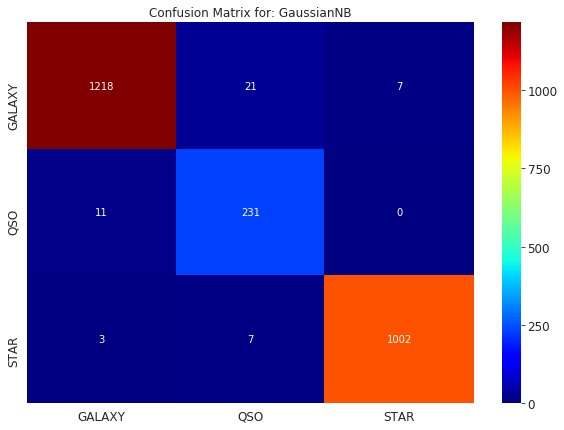

In [5]:
best_indiv = GaussianNB(var_smoothing=3.727593720314938e-11)

clf_names = ["GaussianNB"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs=[best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)